# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Telugu'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'
test_dir_v2 = f'Data/{language}-V2-Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 8 #os.cpu_count()
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

8
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(554, 3)


,Character,Consonant,Glyph
0,అ,-,-
1,ఆ,-,ా
2,ఇ,-,ి
3,ఈ,-,ీ
4,ఉ,-,ు


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

65
['-', 'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ఌ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'క', 'ఖ', 'గ', 'ఘ', 'ఙ', 'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ', 'త', 'థ', 'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ఱ', 'ల', 'ళ', 'ఴ', 'వ', 'శ', 'ష', 'స', 'హ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', 'ౢ']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'అ', 2: 'ఆ', 3: 'ఇ', 4: 'ఈ', 5: 'ఉ', 6: 'ఊ', 7: 'ఋ', 8: 'ఌ', 9: 'ఎ', 10: 'ఏ', 11: 'ఐ', 12: 'ఒ', 13: 'ఓ', 14: 'ఔ', 15: 'క', 16: 'ఖ', 17: 'గ', 18: 'ఘ', 19: 'ఙ', 20: 'చ', 21: 'ఛ', 22: 'జ', 23: 'ఝ', 24: 'ఞ', 25: 'ట', 26: 'ఠ', 27: 'డ', 28: 'ఢ', 29: 'ణ', 30: 'త', 31: 'థ', 32: 'ద', 33: 'ధ', 34: 'న', 35: 'ప', 36: 'ఫ', 37: 'బ', 38: 'భ', 39: 'మ', 40: 'య', 41: 'ర', 42: 'ఱ', 43: 'ల', 44: 'ళ', 45: 'ఴ', 46: 'వ', 47: 'శ', 48: 'ష', 49: 'స', 50: 'హ', 51: 'ా', 52: 'ి', 53: 'ీ', 54: 'ు', 55: 'ూ', 56: 'ృ', 57: 'ె', 58: 'ే', 59: 'ై', 60: 'ొ', 61: 'ో', 62: 'ౌ', 63: '్', 64: 'ౢ'}
{'-': 0, 'అ': 1, 'ఆ': 2, 'ఇ': 3, 'ఈ': 4, 'ఉ': 5, 'ఊ': 6, 'ఋ': 7, 'ఌ': 8, 'ఎ': 9, 'ఏ': 10, 'ఐ': 11, 'ఒ': 12, 'ఓ': 13, 'ఔ': 14, 'క': 15, 'ఖ': 16, 'గ': 17, 'ఘ': 18, 'ఙ': 19, 'చ': 20, 'ఛ': 21, 'జ': 22, 'ఝ': 23, 'ఞ': 24, 'ట': 25, 'ఠ': 26, 'డ': 27, 'ఢ': 28, 'ణ': 29, 'త': 30, 'థ': 31, 'ద': 32, 'ధ': 33, 'న': 34, 'ప': 35, 'ఫ': 36, 'బ': 37, 'భ': 38, 'మ': 39, 'య': 40, 'ర': 41, 'ఱ': 42, 'ల': 43, 'ళ': 44, 'ఴ': 45, 'వ': 46, 'శ': 47, '

# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

# 4. Define model

In [11]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [12]:
for p in resnet.parameters():
    p.requires_grad = False

In [13]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

# 5. Make predictions

In [14]:
batch_size = 64
rnn_hidden_size = 256

In [15]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir)
testset_v2 = IndianSceneTextDataset(test_dir_v2)

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader_v2 = DataLoader(testset_v2, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [16]:
model_path = f'Models/{language}-Unicode-e40.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)
crnn.eval()

CRNN(
  (dp1): Dropout(p=0.5, inplace=False)
  (dp2): Dropout(p=0.5, inplace=False)
  (dp3): Dropout(p=0.5, inplace=False)
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [17]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [18]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [19]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)
test_result_v2 = make_predictions(test_loader_v2)

In [20]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
print(test_result_v2.shape)
train_result.head()

(400000, 3)
(5000, 3)
(5000, 3)
(2307, 3)


,image_fn,actual,prediction
0,వరి_21_1206_2.jpg,వరి,వ----------రి
1,వరి_11_4027_1.jpg,వరి,వ----------రి
2,తన_20_1180_1.jpg,తన,త----------న-
3,వరి_1_4330_0.jpg,వరి,వ----------రి
4,కనప_1_946_4.jpg,కనప,క------న---ప-


In [21]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [22]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)
test_result_v2['prediction_corrected'] = test_result_v2['prediction'].apply(correct_prediction)

In [23]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)
test_result_v2['actual_length'] = test_result_v2['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)
test_result_v2['prediction_length'] = test_result_v2['prediction_corrected'].apply(len)

In [24]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [25]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)
test_result_v2['edit_distance'] = test_result_v2.apply(levenshteinDistance, axis=1)

# 6. Evaluate the model

In [26]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
test_accuracy_v2 = accuracy_score(test_result_v2['actual'], test_result_v2['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2)

0.90932 0.8482 0.8342 0.9570871261378413


In [27]:
accuracy_df = []
for max_edit_distance in range(4+1):
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    test_accuracy_v2 = (test_result_v2['edit_distance'] <= max_edit_distance).sum() / len(test_result_v2)
    accuracy_df.append([max_edit_distance, train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2])
columns=['Max-Edit-Distance', 'Train-Accuracy', 'Val-Accuracy', 'Test-Accuracy', 'V2-Test-Accuracy']
accuracy_df = pd.DataFrame(accuracy_df, columns=columns)
accuracy_df.to_csv(f'Results/{language}.csv', index=False)
accuracy_df

,Max-Edit-Distance,Train-Accuracy,Val-Accuracy,Test-Accuracy,V2-Test-Accuracy
0,0,0.909320,0.8482,0.8342,0.957087
1,1,0.940750,0.8874,0.8824,0.980928
2,2,0.960673,0.9294,0.9212,0.990030
3,3,0.975017,0.9680,0.9570,0.992631
4,4,0.982672,0.9796,0.9742,0.996532


In [28]:
test_result['edit_distance'].describe()

count    5000.000000
mean        0.467400
std         1.319881
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: edit_distance, dtype: float64

In [29]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=1):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
    elif split == "Test-V2":
        result = test_result_v2
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        if split == 'Test-V2':
            image_fp = f'Data/{language}-V2-Test/{row["image_fn"]}'
        else:
            image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

In [30]:
#visualize_misclassifications('Train')

In [31]:
#visualize_misclassifications('Val')

('Actual:', 'వరి', 'Prediction:', 'క----------ర-', 'Prediction Corrected:', 'కర')


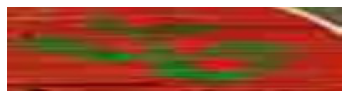

('Actual:', 'ఆశా', 'Prediction:', 'స----------శా', 'Prediction Corrected:', 'సశా')


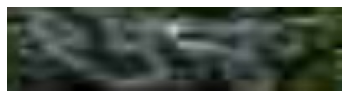

('Actual:', 'తమ', 'Prediction:', 'ఉ----------క-', 'Prediction Corrected:', 'ఉక')


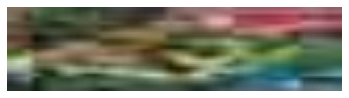

('Actual:', 'గత', 'Prediction:', 'త----------క-', 'Prediction Corrected:', 'తక')


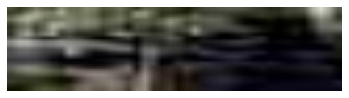

('Actual:', 'అది', 'Prediction:', 'ఆ----------ది', 'Prediction Corrected:', 'ఆది')


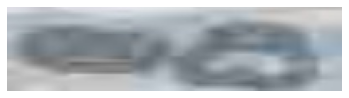

('Actual:', 'ఉప', 'Prediction:', 'క----------వి', 'Prediction Corrected:', 'కవి')


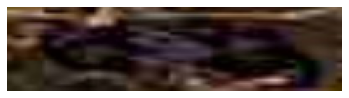

('Actual:', 'భారత', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


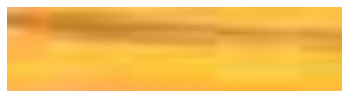

('Actual:', 'మగ', 'Prediction:', 'వ------------', 'Prediction Corrected:', 'వ')


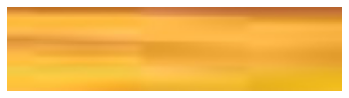

('Actual:', 'పేట', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


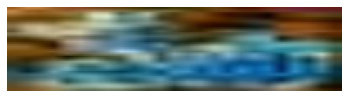

('Actual:', 'ఆమె', 'Prediction:', 'ఆ----------డ-', 'Prediction Corrected:', 'ఆడ')


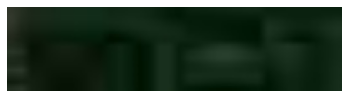

('Actual:', 'మార', 'Prediction:', 'పౌ---------ర-', 'Prediction Corrected:', 'పౌర')


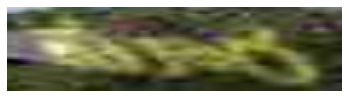

('Actual:', 'పత్తెగడ', 'Prediction:', 'ప--క్తెెగ--ద-', 'Prediction Corrected:', 'పక్తెగద')


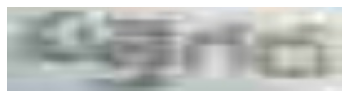

('Actual:', 'చాల', 'Prediction:', 'శా---------ల-', 'Prediction Corrected:', 'శాల')


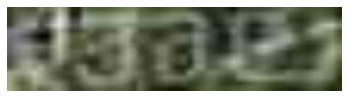

('Actual:', 'పెదతమ్మినగుల', 'Prediction:', 'పెదతమమమనననుుు', 'Prediction Corrected:', 'పెదతమను')


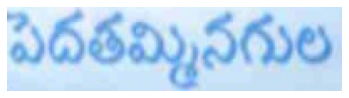

('Actual:', 'బురదకోట', 'Prediction:', 'ఉ---ర-డ---్లి', 'Prediction Corrected:', 'ఉరడ్లి')


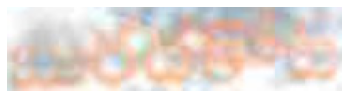

('Actual:', 'అస్థిరత', 'Prediction:', 'అ--స్సి-ర--త-', 'Prediction Corrected:', 'అస్సిరత')


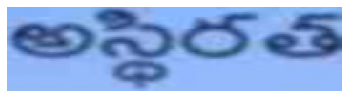

('Actual:', 'అలతూరు', 'Prediction:', 'ఆ--ల---తూూ-రు', 'Prediction Corrected:', 'ఆలతూరు')


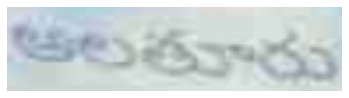

('Actual:', 'వరకు', 'Prediction:', 'వ-----ర----సు', 'Prediction Corrected:', 'వరసు')


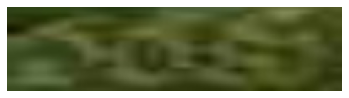

('Actual:', 'మేత', 'Prediction:', 'క----------న-', 'Prediction Corrected:', 'కన')


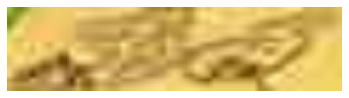

('Actual:', 'చాల', 'Prediction:', 'చౌ---------ళ-', 'Prediction Corrected:', 'చౌళ')


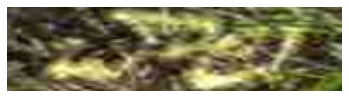

In [32]:
visualize_misclassifications('Test')

('Actual:', 'దాసగణు', 'Prediction:', 'దా---స-గ---ణ-', 'Prediction Corrected:', 'దాసగణ')


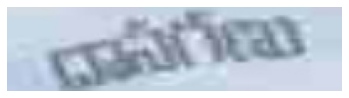

('Actual:', 'పైతర', 'Prediction:', 'పై---ప్త---ర-', 'Prediction Corrected:', 'పైప్తర')


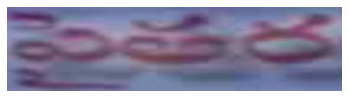

('Actual:', 'శుభనటి', 'Prediction:', 'శుుు--చ-న--టి', 'Prediction Corrected:', 'శుచనటి')


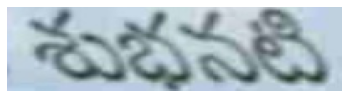

('Actual:', 'వన్చుల', 'Prediction:', 'వ----మ్్మ--ల-', 'Prediction Corrected:', 'వమ్మల')


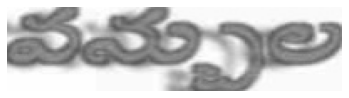

('Actual:', 'ఏర్పరచగల', 'Prediction:', 'ప-ర్పరరచచగగలల', 'Prediction Corrected:', 'పర్పరచగల')


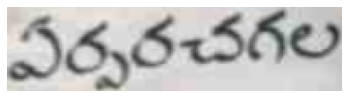

('Actual:', 'దర్పణ', 'Prediction:', 'ద---రర్ష---ణ-', 'Prediction Corrected:', 'దర్షణ')


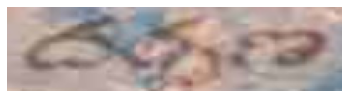

('Actual:', 'చర్ల', 'Prediction:', 'చ------ర్్్ర-', 'Prediction Corrected:', 'చర్ర')


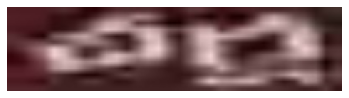

('Actual:', 'వజ్రకరూర్', 'Prediction:', 'వ--జజక--రూ-ళ్', 'Prediction Corrected:', 'వజకరూళ్')


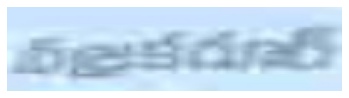

('Actual:', 'బక్స', 'Prediction:', 'బ-----క్్్-క-', 'Prediction Corrected:', 'బక్క')


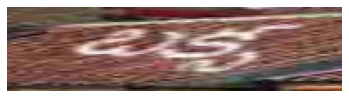

('Actual:', 'సోహగ్గఢఅనడా', 'Prediction:', 'న-నగగగడడల--ము', 'Prediction Corrected:', 'ననగడలము')


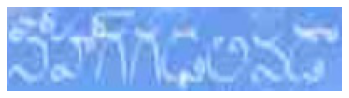

('Actual:', 'వనపర్తి', 'Prediction:', 'ప----న--పర్తి', 'Prediction Corrected:', 'పనపర్తి')


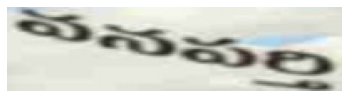

('Actual:', 'పడవద్దనీ', 'Prediction:', 'ప--డడ-వద్ద-ని', 'Prediction Corrected:', 'పడవద్దని')


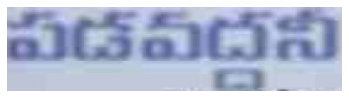

('Actual:', 'ఒక', 'Prediction:', 'ఒ----------రి', 'Prediction Corrected:', 'ఒరి')


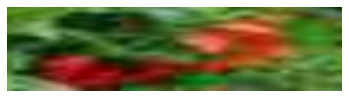

('Actual:', 'చిలకలగూడ', 'Prediction:', 'చ-లలక-ల-గగూడడ', 'Prediction Corrected:', 'చలకలగూడ')


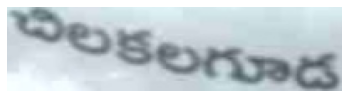

('Actual:', 'ప్రస్తావన', 'Prediction:', 'ప్రరత్తాాత-న-', 'Prediction Corrected:', 'ప్రత్తాతన')


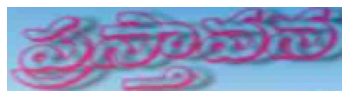

('Actual:', 'ఎస్నల్లబల్లె', 'Prediction:', 'ఎ-స్పల్లబల్లె', 'Prediction Corrected:', 'ఎస్పల్లబల్లె')


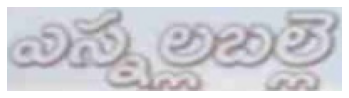

('Actual:', 'అయినది', 'Prediction:', 'అ----య--న--ది', 'Prediction Corrected:', 'అయనది')


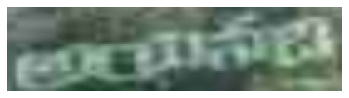

('Actual:', 'జర్జపుపేట', 'Prediction:', 'జ-ర్ల-పు-పేట-', 'Prediction Corrected:', 'జర్లపుపేట')


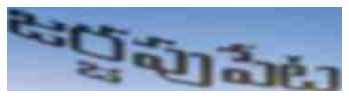

('Actual:', 'గొరదలు', 'Prediction:', 'గ---ర--ద---లు', 'Prediction Corrected:', 'గరదలు')


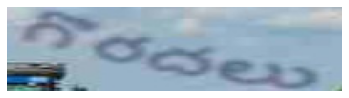

('Actual:', 'నవలలూ', 'Prediction:', 'న---వ-ల----లు', 'Prediction Corrected:', 'నవలలు')


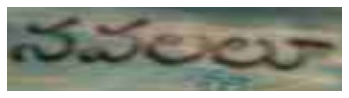

In [33]:
visualize_misclassifications('Test-V2')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [34]:
#test_result